In [1]:
import pandas as pd
import import_ipynb
import analysis_utils as utils
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

importing Jupyter notebook from analysis_utils.ipynb


In [2]:
# Set pandas formating options
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.width = 2000
pd.options.display.max_columns = 10

#### Step 1. Load and clean Airbnb data for Seattle and Boston


In [3]:
# 1.1. load airbnb data using UDF
data_type = ['calendar'
             , 'listings'
             , 'reviews']

city_type = ['seattle'
             , 'boston']

city_dictionary = utils.load_csv(city_type, data_type, 'data')

In [14]:
# 1.2. create separate dataframes for each city and data set
reviews_df = utils.concatenate_dataframes(city_dictionary, 'reviews')
calendar_df = utils.concatenate_dataframes(city_dictionary, 'calendar')
listings_df = utils.concatenate_dataframes(city_dictionary, 'listings')

# Convert host_since_year to numetic value
listings_df['host_since_year'] = pd.to_numeric(listings_df['host_since_year'], errors='coerce')

#### Step 2. Assess size of the data and the amount of missing data

In [15]:
# 2.1.  check shape of the listings df
print(listings_df[listings_df['boston'] == 1].shape)
print(listings_df[listings_df['boston'] == 0].shape)
# seattle has slighlty more observations

(3585, 99)
(3818, 99)


In [16]:
# 2.2. check missing data in the whole data dataset
# create a list of columns that have more than 50% of missing data to drop then later
columns_with_missing_values = utils.check_missing_values(listings_df, 0.5)

                           index  seattle  boston
78                       license     1.00    1.00
49            jurisdiction_names     0.00    1.00
57              has_availability     0.00    1.00
75  neighbourhood_group_cleansed     0.00    1.00
81                   square_feet     0.97    0.98
43           monthly_price_float     0.60    0.75
80                 monthly_price     0.60    0.75
87                  weekly_price     0.47    0.75
92            weekly_price_float     0.47    0.75
50              security_deposit     0.51    0.63
32                         notes     0.42    0.55
39         neighborhood_overview     0.27    0.39
48                    host_about     0.22    0.37
82                       transit     0.24    0.36
25                  cleaning_fee     0.27    0.31
22                         space     0.15    0.29
58        review_scores_accuracy     0.17    0.23
29        review_scores_location     0.17    0.23
2            review_scores_value     0.17    0.23


In [17]:
# 2.3. Check missing data in categorical series only
string_columns = list(set(listings_df.select_dtypes(include=['object']).columns)) + ['boston']
utils.check_missing_values(listings_df[string_columns], 0.5)

                               index  seattle  boston
3                 jurisdiction_names     0.00    1.00
28                  has_availability     0.00    1.00
62      neighbourhood_group_cleansed     0.00    1.00
8                      monthly_price     0.60    0.75
21                      weekly_price     0.47    0.75
6                   security_deposit     0.51    0.63
12                             notes     0.42    0.55
35             neighborhood_overview     0.27    0.39
0                         host_about     0.22    0.37
9                            transit     0.24    0.36
61                      cleaning_fee     0.27    0.31
57                             space     0.15    0.29
11                       last_review     0.16    0.21
34                      first_review     0.16    0.21
2                      thumbnail_url     0.08    0.17
42                        medium_url     0.08    0.17
51                    xl_picture_url     0.08    0.17
45                     neigh

['jurisdiction_names',
 'has_availability',
 'neighbourhood_group_cleansed',
 'monthly_price',
 'weekly_price',
 'security_deposit',
 'notes']

In [18]:
# 2.4. Check missing data in numerical series only
numeric_columns = list(set(listings_df.select_dtypes(include=['int64','float64']).columns))
utils.check_missing_values(listings_df[numeric_columns], 0.5)

                             index  seattle  boston
2                          license     1.00    1.00
8                      square_feet     0.97    0.98
20             monthly_price_float     0.60    0.75
21              weekly_price_float     0.47    0.75
16          review_scores_accuracy     0.17    0.23
1           review_scores_location     0.17    0.23
9              review_scores_value     0.17    0.23
24           review_scores_checkin     0.17    0.23
18       review_scores_cleanliness     0.17    0.23
27     review_scores_communication     0.17    0.23
17            review_scores_rating     0.17    0.23
12               reviews_per_month     0.16    0.21
28                       bathrooms     0.00    0.00
32                        bedrooms     0.00    0.00
14                            beds     0.00    0.00
7                  host_since_year     0.00    0.00
23             host_listings_count     0.00    0.00
30       host_total_listings_count     0.00    0.00
0           

['license', 'square_feet', 'monthly_price_float', 'weekly_price_float']

In [19]:
# 2.5. check missing values after droping columns with more than 50 percent of missing values
columns_with_missing_values = utils.check_missing_values(listings_df, 0.5)

                           index  seattle  boston
78                       license     1.00    1.00
49            jurisdiction_names     0.00    1.00
57              has_availability     0.00    1.00
75  neighbourhood_group_cleansed     0.00    1.00
81                   square_feet     0.97    0.98
43           monthly_price_float     0.60    0.75
80                 monthly_price     0.60    0.75
87                  weekly_price     0.47    0.75
92            weekly_price_float     0.47    0.75
50              security_deposit     0.51    0.63
32                         notes     0.42    0.55
39         neighborhood_overview     0.27    0.39
48                    host_about     0.22    0.37
82                       transit     0.24    0.36
25                  cleaning_fee     0.27    0.31
22                         space     0.15    0.29
58        review_scores_accuracy     0.17    0.23
29        review_scores_location     0.17    0.23
2            review_scores_value     0.17    0.23


#### Step 3. Clean data: 
**1.** Remove irrelevant columns and columns where missing values exceed 50 percent

**2.** Replace missing values of numeric columns with its mean

In [20]:
# 3.1. drop url and scrapping related columns
listings_df = utils.drop_specified_columns('url', listings_df)
listings_df = utils.drop_specified_columns('scrap', listings_df)

In [21]:
# 3.2. drop non informative columns
# exclude_colums is the list of columsn that contains information that is not useful in prediction of the price
exclude_columns = ['id'
                , 'host_id'
                , 'host_listings_count'
                , 'host_total_listings_count'
                , 'neighborhood_overview'
                , 'host_neighbourhood'
                , 'host_about'
                , 'transit'
                , 'neighbourhood'
                , 'latitude'
                , 'longitude'
                , 'last_review'
                , 'first_review'
                , 'summary'
                , 'zipcode'
                , 'host_location'
                , 'state'
                , 'country'
                , 'market'
                , 'space'
                , 'cleaning_fee'
                , 'host_acceptance_rate'
                , 'host_response_rate']
try:
    listings_df = listings_df.drop(columns=exclude_columns)
except KeyError:
    print('Columns already deleted')

In [42]:
# 3.3. drop columns that have more than 50% of data missing
try:
    listings_df = listings_df.drop(columns=columns_with_missing_values)
except KeyError:
    print('Columns already deleted')

Columns already deleted


In [43]:
# 3.7. replace missing numeric values with mean values for each city
numeric_columns = listings_df.select_dtypes(include=['float64','int64']).columns
boston_listing_df = listings_df[listings_df['boston'] == 1].reset_index(drop=True)
seattle_listing_df = listings_df[listings_df['boston'] == 0].reset_index(drop=True)

def fillna_with_mean(numeric_series):
    """
    Function to fill nans of numeric series with its mean
    :param data: numeric series
    :return: numeric series with nans replaced by its mean
    """
    numeric_series = numeric_series.fillna(numeric_series.mean())
    return numeric_series
# fill numeric nans with means
for col in numeric_columns:
    boston_listing_df[col] = fillna_with_mean(boston_listing_df[col])
    seattle_listing_df[col] = fillna_with_mean(seattle_listing_df[col])
filled_listings_df = pd.concat([boston_listing_df, seattle_listing_df]).reset_index(drop=True)

# check that numeric columns have nans filled
utils.check_missing_values(filled_listings_df.select_dtypes(include=['float64','int64']), 0.5)  

                             index  seattle  boston
0                  host_since_year     0.00    0.00
1              review_scores_value     0.00    0.00
2                number_of_reviews     0.00    0.00
3             review_scores_rating     0.00    0.00
4        review_scores_cleanliness     0.00    0.00
5                 availability_365     0.00    0.00
6                  availability_90     0.00    0.00
7      review_scores_communication     0.00    0.00
8                  availability_30     0.00    0.00
9           review_scores_location     0.00    0.00
10                 availability_60     0.00    0.00
11               reviews_per_month     0.00    0.00
12                 guests_included     0.00    0.00
13  calculated_host_listings_count     0.00    0.00
14                  minimum_nights     0.00    0.00
15          review_scores_accuracy     0.00    0.00
16                          boston     0.00    0.00
17                  maximum_nights     0.00    0.00
18          

[]

In [56]:
# check what categorical variables have missing values
utils.check_missing_values(filled_listings_df[list(filled_listings_df.select_dtypes(include=['object']).columns) + ['boston']], 0.5)  
# The only column that has missing values is host_response_time
# Only about 14% is missing from each city data
# Since I am interested in the impact of this variable in the price and there are only 14% of missing data 
# I can drop the records with missing data without loosing a lot of variation in the data
filled_cleaned_listings_df = filled_listings_df.dropna()
filled_cleaned_listings_df.shape

                               index  seattle  boston
8                 host_response_time     0.14    0.13
0                  host_is_superhost     0.00    0.00
7               host_has_profile_pic     0.00    0.00
10            host_identity_verified     0.00    0.00
1                   instant_bookable     0.00    0.00
2   require_guest_phone_verification     0.00    0.00
3                  is_location_exact     0.00    0.00
4      require_guest_profile_picture     0.00    0.00
5                cancellation_policy     0.00    0.00
6                           bed_type     0.00    0.00
9                          room_type     0.00    0.00
11                            boston     0.00    0.00


(6409, 28)

#### Step 4. Analyze and Visualize data: compare numeric and categorical columns between two cities

In [57]:
# 4.1. describe all numeric columns in both cities
utils.compare_all_float_columns(listings_df)
#Boston has larger minimum_nights mean
#Boston has lower review scores mean
#Boston has higher mean price
#Boston has less beds mean


 Describe host_since_year
   index  host_since_year_seattle  host_since_year-boston
0  count                  3816.00                 3585.00
1   mean                  2013.21                 2013.75
2    std                     1.56                    1.72
3    min                  2008.00                 2008.00
4    25%                  2012.00                 2013.00
5    50%                  2013.00                 2014.00
6    75%                  2015.00                 2015.00
7    max                  2016.00                 2016.00

 Describe review_scores_value
   index  review_scores_value_seattle  review_scores_value-boston
0  count                      3162.00                     2764.00
1   mean                         9.45                        9.17
2    std                         0.75                        1.01
3    min                         2.00                        2.00
4    25%                         9.00                        9.00
5    50%                

                             mean-seattle  mean-boston
minimum_nights                       2.37         3.17
bedrooms                             1.31         1.26
bathrooms                            1.26         1.22
guests_included                      1.67         1.43
accommodates                         3.35         3.04
review_scores_value                  9.45         9.17
number_of_reviews                   22.22        19.04
review_scores_cleanliness            9.56         9.26
review_scores_communication          9.81         9.65
review_scores_location               9.61         9.41
reviews_per_month                    2.08         1.97
review_scores_accuracy               9.64         9.43
review_scores_checkin                9.79         9.65


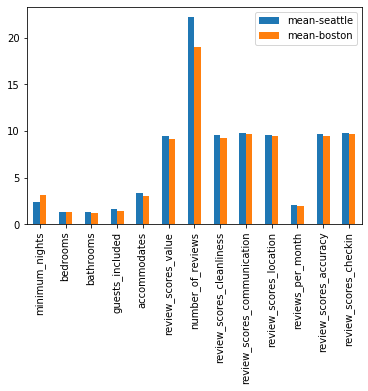

             mean-seattle  mean-boston
price_float        127.98       173.93


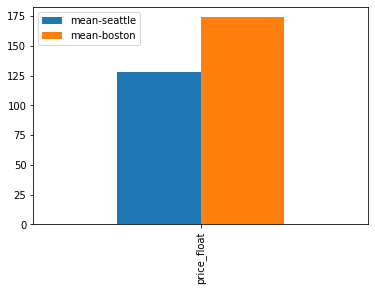

                      mean-seattle  mean-boston
review_scores_rating         94.54        91.92


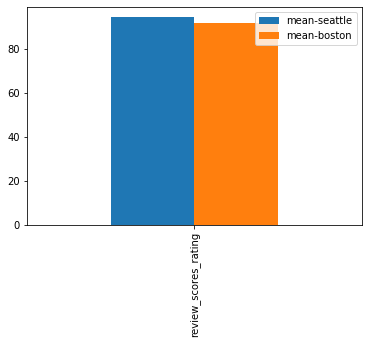

In [58]:
# summarize price, reviews and property attributes in a single summary
# create list of columns containing review string
review_columns = [col for col in listings_df.columns if 'review' in col] 

# create list of additional columns of interest
specific_columns = ['minimum_nights'
                   , 'bedrooms'
                   , 'bathrooms'
                   , 'guests_included'
                   , 'accommodates']

# create a combine list of numeric columns of interest
numeric_columns_to_describe = specific_columns + review_columns

# review_scores_rating has different magnitude so should be plotted seprately
numeric_columns_to_describe.remove('review_scores_rating')

# compare selected numeric columns
utils.compare_specified_float_columns(listings_df, numeric_columns_to_describe, 'mean')

# compare price
utils.compare_specified_float_columns(listings_df, ['price_float'], 'mean')

# compare review score
utils.compare_specified_float_columns(listings_df, ['review_scores_rating'], 'mean')

# create list of numeric columns to use in analysis
numeric_columns_to_describe = numeric_columns_to_describe + ['host_since_year', 'review_scores_rating']
# Price mean is higher in Boston but raitings mean is higher in Seattle

In [59]:
# 4.2. describe relationship between price and vaategorical values between two cities

# create list of string columns that have up to 6 different values in oder to make categorical predictors
values_freq = {}
for col in filled_listings_df.select_dtypes(include=['object']):
    values_freq[col] = len(filled_listings_df[col].drop_duplicates())
values_freq = {k: v for k, v in sorted(values_freq.items(), key=lambda item: item[1], reverse=False)}
print(values_freq)

# judjing by the amount of the distinct values in the categorical columns it makes sense to use only those with
# less of 6 distinct values as columns with more distinct values would create 
# a large amount of dimentions while not adding much to explanatory power
values_freq = {k: v for k, v in filter(lambda item: 1 < item[1] < 6, values_freq.items())}
categorical_columns_to_describe = set(values_freq.keys())
print(categorical_columns_to_describe)

{'instant_bookable': 2, 'require_guest_phone_verification': 2, 'is_location_exact': 2, 'require_guest_profile_picture': 2, 'host_is_superhost': 3, 'host_has_profile_pic': 3, 'room_type': 3, 'host_identity_verified': 3, 'cancellation_policy': 4, 'bed_type': 5, 'host_response_time': 5}
{'host_is_superhost', 'instant_bookable', 'is_location_exact', 'require_guest_phone_verification', 'require_guest_profile_picture', 'cancellation_policy', 'bed_type', 'host_has_profile_pic', 'host_response_time', 'room_type', 'host_identity_verified'}


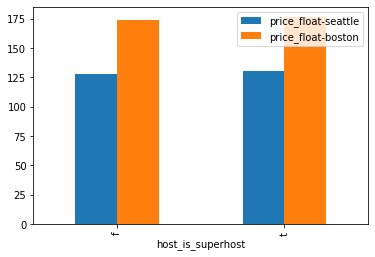

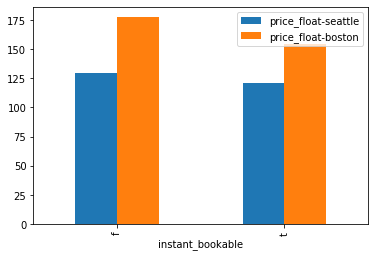

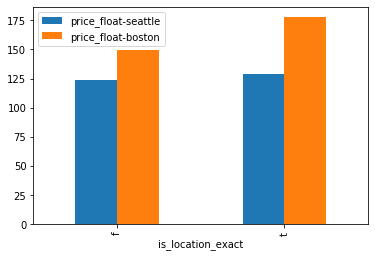

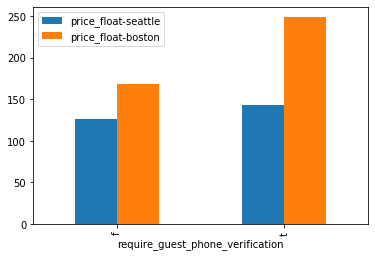

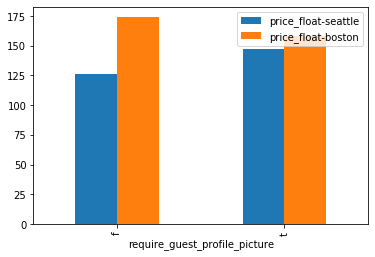

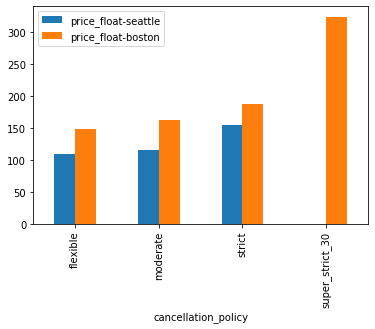

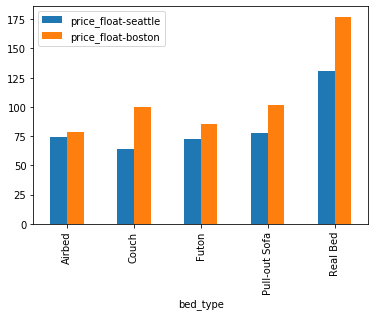

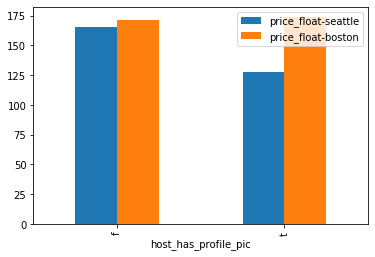

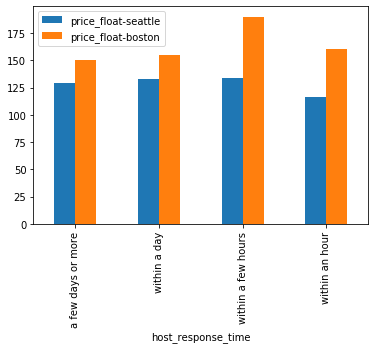

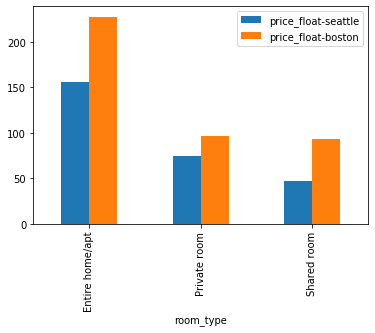

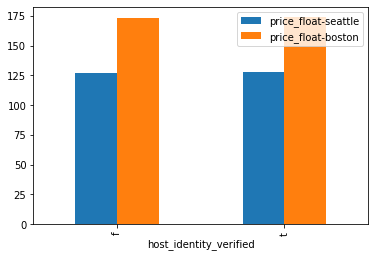

In [60]:
# compare numeric data across 2 cities grouping on each categorical column of interest
for col in categorical_columns_to_describe:
    utils.compare_grouby_results(filled_listings_df, [col], ['price_float'], 'mean')
#Boston has a premium for fast responses but not for the fastest
#Boston has super stric policy -> the stricter the policy the more expensive
#Super host has little effect
#Airbeds in seattle seem to be more appreciated than couches

In [61]:
# 4.3. create dummies for selected categorical variables
for col in categorical_columns_to_describe:
    # for each cat add dummy var, drop original column
    filled_cleaned_listings_df = pd.concat([filled_cleaned_listings_df.drop(col, axis=1)
                                        , pd.get_dummies(filled_cleaned_listings_df[col]
                                                         , prefix=col, prefix_sep='_', drop_first=True)], axis=1)
#drop super stric cancelation policy because it is only in boston
filled_cleaned_listings_df = filled_cleaned_listings_df.drop(columns=['cancellation_policy_super_strict_30'])
# keep only the columns of interest
filled_cleaned_listings_df = filled_cleaned_listings_df[['boston', 'price_float'] + list(numeric_columns_to_describe) + list(categorical_columns_to_describe)]

KeyError: "['host_is_superhost', 'instant_bookable', 'require_guest_phone_verification', 'require_guest_profile_picture', 'is_location_exact', 'cancellation_policy', 'bed_type', 'host_has_profile_pic', 'host_response_time', 'room_type', 'host_identity_verified'] not in index"

#### Step 5. Model data

**1.** Run linear regression on listings data study the predictors of the prices in two cities

**2.** Run linear regression on calendar data to see appartment price seasonality and time trend

In [68]:
# 5.1.1. Check what city is on average more expensive
city_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'])
city_results['coefficients'].head()
#Boston is more expensive

,Coefficient
boston,46.92


In [69]:
print(city_results['r2_test'])
# Boston seem to be a more expensive city but just having one regressor does not explain much of price volatility

0.047836900268108606


In [70]:
# 5.1.2. Check if reviews are stronger price predictors than bed and bathrooms
numeric_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'] + numeric_columns_to_describe)
numeric_results['coefficients'].head(len(numeric_columns_to_describe) + 1)
# Boston remains a strong predictor of price even holding everything else constant
# Bedrooms, accomodates and bathrooms are as stronger predictors than reviews but score of location matters a lot as well
# Raiting does not matter
# Value score is negaative as expected because if signals a good deal
# Having a host with longer experience does not increase prices

,Coefficient
boston,58.88
review_scores_location,25.09
bedrooms,21.99
accommodates,21.03
bathrooms,19.88
review_scores_cleanliness,8.83
guests_included,1.43
review_scores_rating,0.99
minimum_nights,0.15
number_of_reviews,-0.12


In [65]:
print(numeric_results['r2_test'])
# Boston is a strong predictor of price, quality of location is also important as well as size of the appartment

0.5005846237898239


In [71]:
# 5.1.3. Check if categorical values are stronger predictors than numeric predictors
columns_of_interest = list(filled_cleaned_listings_df.columns)
columns_of_interest.remove('price_float')
total_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], columns_of_interest)
total_results['coefficients'].head(len(columns_of_interest)+1)
# Phone verification is associated with more expensive accomodations
# Couch is more expensive than a real bed
# Host that replies in couple of hours earns more than host replyiong within an hour? 
# Number of reviews have negative effect on price

,Coefficient
boston,57.09
require_guest_phone_verification_t,49.01
bedrooms,29.90
bathrooms,25.84
bed_type_Couch,21.67
review_scores_location,16.68
bed_type_Real Bed,13.73
host_is_superhost_t,10.96
accommodates,10.06
bed_type_Pull-out Sofa,8.11


In [72]:
print(total_results['r2_test'])

0.5678415968873329


In [ ]:
# 22. Check missing values in calendar df
calendar_df = calendar_df.drop(columns=['listing_id','date_day','date','available','price'])
utils.check_missing_values(calendar_df, 0.5) 
calendar_df = calendar_df.dropna().reset_index(drop=True)

In [ ]:
# 23. Create city, year, city-year interaction dummies
calendar_df['2017_year'] = np.where(calendar_df['date_year'] == '2017', 1, 0)
calendar_df['2017_year_boston'] = calendar_df['2017_year'].multiply(calendar_df['boston'])
utils.check_missing_values(calendar_df, 0.5) 

In [ ]:
# even after dropping missing it is a large dataset
calendar_df.shape

In [ ]:
# 24. Check if prices decreased in 2017
columns_of_interest = ['2017_year', 'boston', '2017_year_boston']
trends_results = utils.run_linear_regression(calendar_df, ['price_float'], columns_of_interest)
trends_results['coefficients'].head(len(columns_of_interest)+1)
# Boson is +75 in 2016
# seattle prices decreased by 2 dollars in 2017
# Boston prices decreased  by about 21 dollars in 2017

In [ ]:
calendar_df.groupby(['boston','2017_year'])['date_month'].value_counts()

In [ ]:
# 25. create monthly dummies to check what is the best month to com
monthly_calendar_df = pd.concat([calendar_df.drop('date_month', axis=1)
                            , pd.get_dummies(calendar_df['date_month']
                                             , prefix='month', prefix_sep='_', drop_first=True)], axis=1)
monthly_calendar_df = monthly_calendar_df.drop(columns=['date_year'])
columns_of_interest = [col for col in monthly_calendar_df.columns if 'month_' in col] 

In [ ]:
# 26. Check what month is cheapest for tourists
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , columns_of_interest + ['boston','2017_year','2017_year_boston'])
monthly_results['coefficients'].head(len(columns_of_interest)+3)
# The sign of 2017_year flips to positive 
# suggeting that seattle prices increased in 2017 in comparison to 2016 rather tahn dropped
# the reason is that now we control for seasonality and previously we saw the effect of 
# having only relatively cheaper winter months for 2017 seattle dataset

In [ ]:
# 27. Check what month is cheapest for tourists separately in Boston and Seattle
monthly_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
for col in monthly_columns:
    monthly_calendar_df['boston_' + col] = monthly_calendar_df['boston']*monthly_calendar_df[col]

In [ ]:
monthly_interaction_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , monthly_interaction_columns + ['boston'])
monthly_results['coefficients'].head(len(monthly_interaction_columns)+3)

In [ ]:
# 27. combine coefficients for Seattle and Boston to infere overall change of prices in Boston in comparison to January
coefficients_df = monthly_results['coefficients'].sort_index()
boston_coefficients_df = coefficients_df[coefficients_df.index.str.contains('boston') 
                                         & (coefficients_df.index != 'boston')].reset_index(drop=True)
seattle_coefficients_df = coefficients_df[~coefficients_df.index.str.contains('boston')].reset_index(drop=True)

In [ ]:
seasonality_df = boston_coefficients_df.merge(seattle_coefficients_df, left_index=True, right_index=True)
seasonality_df.index = ['Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']

In [ ]:
seasonality_df.columns = ['Season_Impact_Boston', 'Season_Impact_Seattle']
seasonality_df['Season_Impact_Boston'] = seasonality_df['Season_Impact_Boston'] + seasonality_df['Season_Impact_Seattle']

In [ ]:
# Sort values for Boston
seasonality_df[['Season_Impact_Boston']].sort_values('Season_Impact_Boston').head(11)

In [ ]:
# Sort values for Seattle
seasonality_df[['Season_Impact_Seattle']].sort_values('Season_Impact_Seattle').head(11)         